## Unspoiled - Phantom Tracker
#### Ben Cobb

Spring 2024

## Imports and Libraries

In [3]:
import sys
import io
import os
import time
import base64
import datetime
import requests

import cv2 as cv
from PIL import Image
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Classes

In [14]:
class Camera:
    def __init__(self, camID, deptID):
        self.camID = camID
        self.deptID = deptID
        self.cap = None  # VideoCapture
        
    # Opens the camera
    def startCamera(self):
        self.cap = cv.VideoCapture(self.camID)
        if not self.cap.isOpened():
            raise RuntimeError(f"Error opening camera: {self.camID}")
        else:
            # Changes the resolution if it defaults to 640x480 (it does this a lot)
            self.cap.set(cv.CAP_PROP_FRAME_WIDTH, 1280)
            self.cap.set(cv.CAP_PROP_FRAME_HEIGHT, 720)
            self.cap.set(38, 1)   # Don't know if this ever ended up doing anything, but I'm too afraid to remove it now

    # Takes a pic
    def takePic(self):
        # Checks if the camera is open
        if self.cap is None or not self.cap.isOpened():
            raise RuntimeError("Camera is not open!")

        # Does the pic-taking
        ret, frame = self.cap.read()
        if not ret:
            raise RuntimeError("Error capturing frame...")

        return frame

    # Stops he camera
    def stopCamera(self):
        if self.cap is not None:
            self.cap.release()
            self.cap = None

    def isOpened(self):
        return self.isOpened()

    ###########
    # GET/SET #
    ###########
    def getCamID(self):
        return self.camID

    def setCamID(self, camID):
        self.camID = camID

    def getDeptID(self):
        return self.deptID

    def setDeptID(self, deptID):
        self.deptID = deptID

# Global Variables

In [18]:
###############
# CAMERA VARS #
###############
interval = 5    # Num seconds to wait before taking another pic

# UNCOMMENT THE ONES WE'LL NEED, AND CHANGE THE IDS AND DEPTS IF NEEDED
# Dictionary of <camID, camDept>
camDict = {
    0 : 0,  # COLD
 #   2 : 1,   # PRODUCE
 #   4 : 2   # PACKAGED
}

# Sets up a list of Camera objects and opens them (sometimes takes longer than expected, at least for me)
cams = []
for camID in camDict:
    cam = Camera(camID=camID, deptID=camDict.get(camID))
    cams.append(cam)

##############
# CLASS INFO #
##############
numItems = 9   # CHANGE THIS LATER. MAYBE AS A DB CALL FOR INV SIZE?
deptNames = ["COLD", "PRODUCE", "PACKAGED"]
classes = ["MILK", "EGGCARTON", "CREAMER", "APPLE", "BANANA", "PEAR", "COUGHDROPS", "CHEEZIT", "SODA"]
'''
classIDs:
0 = "milk"
1 = "eggcarton"
2 = "creamer"
3 = "apple"
4 = "banana"
5 = "pear"
6 = "coughdrops"18 hours ago
7 = "cheezit"
8 = "soda"
'''

##############
# MODEL VARS #
##############

# Sets up the model with our best weights
# CHANGE THIS TO WHEREVER WE HAVE THESE STORED
model = YOLO('best.pt')

# Shows the model's info (obviously), good for confirming your paths are working
# model.info()

confLimit = 50   # the minimum percent confidence limit

##############
# CONNECTION #
##############
ip = "74.117.171.112"
port = "32008"
connURL = f"http://{ip}:{port}"

########
# URLS #
########
checkDeptURL = f"{connURL}/Inventory/GetInventoryItem/"
checkPhantomURL = f"{connURL}/Phantom/GetAllPhantomsByCenter/"
createPhantomURL = f"{connURL}/Phantom/CreatePhantom/"
updateEstQtysURL = f"{connURL}/Inventory/UpdateInventoryItemQty"
# saveImgURL = f"{connURL}/images/UploadImage/"   # No longer in use

#########
# OTHER #
#########
cmap = "gray"   # for displaying images

# Methods

In [4]:
# Starts the cameras
def startCams():
    for cam in cams:
        cam.startCamera()

In [5]:
# Checks the bounding boxes the model identified
def checkBoxes(boxes, camDeptID, img):
    
    camDeptName = deptNames[camDeptID]   # Name of dept, for test printing purposes
    
    # Tracking counts
    itemsFound = 0
    phantomsFound = 0
    phantomsLogged = 0
    estQtyDict = {}   # Dictionary of <itemID : estQty>, tracker over an iteration
    
    numBoxes = len(boxes)
    if numBoxes > 0:
            
        # classIDs, confidence scores, and the normalized centerX, centerY, width, and height values
        classIDs = boxes.cls
        confs = boxes.conf
        xywhns = boxes.xywhn
        
        # Loops through the found boxes
        for i in range(numBoxes):
            
            classID = int(classIDs[i].item())
            conf = round(confs[i].item() * 100, 2)
            xywhn = xywhns[i].tolist()
            
            # print(f"{classID} || {conf:.2f}% || {xywhn}")

            # If the model's confidence is above a threshold that we've set,
            if conf > confLimit:
                
                itemsFound += 1
                
                # If this classID has already been counted at least once in this image...
                if classID in estQtyDict:
                    currQty = estQtyDict.get(classID)  # The total value of this item so far
                    itemEstQtyTotal.update({classID: currQty + 1}) 
                
                # If this classID is new to this image...
                else:
                    estQtyDict[classID] = 1


                # Check's the item's department
                deptMatch, deptID = checkDept(classID, camDeptID)
                print(f"{classes[classID]} found in the {camDeptName} department!")
                
                # Item where it should be!
                if deptMatch:
                    print("All good!")
                
                # Returned an error...
                if deptID < 0:
                    # -1 - no such item
                    # -2 - specific connection error
                    # -3 - no connection at all
                    print("DEPTID ERROR:", deptID)
                
                # Item does not belong here! Phantom item found!
                elif not deptMatch:
                    
                    phantomsFound += 1
                    print("Uh-oh! Phantom located!")  
                    
                    centerX = round(float(xywhn[0]), 6)
                    centerY = round(float(xywhn[1]), 6)
                    width = round(float(xywhn[2]), 6)
                    height = round(float(xywhn[3]), 6)
                    
                    # Checks the PHANTOMS table to see if the item has already been logged
                    phantomMatch, deptID = checkPhantom(classID, camDeptID, centerX, centerY)
                    
                    # If the item HAS been logged...
                    if phantomMatch:
                        print("Item already logged!")  
                        
                    # If the item HASN'T been logged, creates and inserts a new entry to the PHANTOMS table
                    else:
                        inserted = createPhantom(classID, camDeptID, centerX, centerY, width, height, img)
                        if inserted:
                            print("Phantom inserted successfully!")
                        else:
                            phantomsLogged += 1
                            print("PHANTOM ITEM NOT CREATED... UH-OH...")
                print("--------------")

    return estQtyDict, itemsFound, phantomsFound, phantomsLogged

In [6]:
# Checks the item's department, returns true if matches camDeptID
def checkDept(classID, camDeptID):

    match = False
    deptID = -1
        
    # Attempt a connection
    try:
       # response = requests.get(f"{checkDeptURL}{str(classID)}")    
        response = requests.get(f"{checkDeptURL}?invId={str(classID)}")    
        
        statusCode = response.status_code

        # We're in!
        if statusCode == 200:
            
            # Parses the response JSON
            data = response.json()
    
            # If the ID doesn't exist
            if not data["success"]:
                print("NO SUCH ITEM!")
                deptID = -1
                
            # If the ID DOES exist
            else:
                deptID = data["inventory"]["deptId"]
                if camDeptID == deptID:   # Item is in correct department
                    match = True
                    
        else:
            print("CONNECTION ERROR: ", statusCode)
            deptID = -2
               
    except:
        print("UNEXPECTED CONNECTION ERROR!!!")
        print("Possibly the server isn't open?")
        deptID = -3
        
    return match, deptID

In [7]:
# Checks the PHANTOMS table to see if it's already been logged, returns true if so
def checkPhantom(classID, camDeptID, centerX, centerY):

    match = False
    deptID = -1
    
    # Calculates the range of the center coords
    epsilon = .05
    centerXMin = str(round(centerX - .05, 6))
    centerXMax = str(round(centerX + .05, 6))
    centerYMin = str(round(centerY - .05, 6))
    centerYMax = str(round(centerY + .05, 6))
        
    # Attempts a connection
    try:
        response = requests.get(f"{checkPhantomURL}{centerXMin}/{centerXMax}/{centerYMin}/{centerYMax}")
        statusCode = response.status_code
        
        # We're in!
        if statusCode == 200:
            
            # Parses the response JSON
            data = response.json()
    
            # If nothing is found...
            if not data["success"]:
                print("NO SUCH PHANTOM!")
                deptID = -1
                
            # If PHANTOM DOES exist
            else:
                
                # Go through list of returned PHANTOMS to see if there's one that matches the itemID and departmentID
                phantoms = data["phantoms"] # ?
                for i in range(len(phantoms)):
                    
                    deptID = phantoms[i]["deptCurrent"]
                    if camDeptID == deptID:   # Item is in correct department
                        match = True
                        
        else:
            print("CONNECTION ERROR: ", statusCode)
            deptID = -2
                   
    except:
        print("UNEXPECTED CONNECTION ERROR!!!")
        print("Possibly the server isn't open?")
        deptID = -3

    return match, deptID

In [8]:
# Creates a Phantom for the PHANTOMS table, return True if successful
def createPhantom(classID, camDeptID, centerX, centerY, width, height, img):

    inserted = False
    dateFound = datetime.datetime.now().isoformat()

    # Crops the box and encodes it in Base64 bytes
    boxImg = cropBox(dateFound, centerX, centerY, width, height, img)
    imgBase64 = encodeBox(boxImg)
    
    phantom = {
        "centerX": centerX,
        "centerY": centerY,
        "claimed": False,
        "deptCurrent": camDeptID,
        "empId": 0, 
        "height": height,
        "imgData": imgBase64,
        "invId": classID,
        "phantomId": 0,
        "returned": False,
        "timeFound": dateFound,
        "width": width
    }

    # Attempts a connection
    try:
        response = requests.post(createPhantomURL, json=phantom)
        statusCode = response.status_code
        
        # We're in!
        if statusCode == 200:
            inserted = True
        else:
            print(f"ERROR CREATING NEW PHANTOM -- STATUS CODE: {statusCode}")

    except:
        print("UNEXPECTED CONNECTION ERROR!!!")
        print("Possibly the server isn't open?")
    
    return inserted

In [9]:
# Crops image to relevant box and returns it
def cropBox(dateFound, centerX, centerY, width, height, img):
    
    # Gets image width and height
    imgWidth, imgHeight = img.size

    # Calculate pixel coordinates from centerX, centerY, width, and height
    minX = int((centerX - width / 2) * imgWidth)
    minY = int((centerY - height / 2) * imgHeight)
    maxX = int((centerX + width / 2) * imgWidth)
    maxY = int((centerY + height / 2) * imgHeight)

    # Crops the image to just the area of the bounding box
    boxImg = img.crop((minX, minY, maxX, maxY))
    
    return boxImg

In [10]:
# Encodes boxImg as Base64 encoded bytes
def encodeBox(boxImg):

    # Converts image to bytes (BLOB?)
    with io.BytesIO() as output:
        boxImg.save(output, format="PNG")
        imgBytes = output.getvalue()
        imgBase64 = base64.b64encode(imgBytes).decode('utf-8')
    
    return imgBase64

In [11]:
# Updates the total itemEstQtyTotal Dictionary, returns the itemEstQtyTotal
def updateEstQtysHere(itemEstQtyTotal, estQtyDict):
   
    for itemID in estQtyDict:

        estQty = estQtyDict.get(itemID)   # Qty counted of this item in this instance

        # If this itemID has already been counted at least once this iteration...
        if itemID in itemEstQtyTotal:
            currQty = itemEstQtyTotal.get(itemID)  # The total value of this item so far
            itemEstQtyTotal.update({itemID: estQty + currQty}) 
        
        # If this itemID is new to this iteration...
        else:
            itemEstQtyTotal[itemID] = estQty
    
    return itemEstQtyTotal

In [12]:
# Updates the items' estQty fields in the Inventory table 
def updateEstQtysInDB(itemEstQtyTotal):

    allUpdated = True
    itemsAdded = 0

    for itemID in itemEstQtyTotal:
        
        estQty = itemEstQtyTotal.get(itemID)
        
        # Attempts a connection
        try:
            data = {
                'estQty': estQty,
                'itemID': itemID
            }
            response = requests.patch(f"{updateEstQtysURL}?estQty={estQty}&itemID={itemID}", json=data)
            
            statusCode = response.status_code
            
            # We're in!
            if statusCode == 200:
                
                # Parses the response JSON
                data = response.json()
        
                # If nothing is found...
                if not data["success"]:
                    print("NO SUCH ITEM! WHAT???")
                    allUpdated = False
                else:
                    print(f"Item {itemID} was updated by {estQty}!")   # Test print
                    itemsAdded += 1
            else:
                print("CONNECTION ERROR: ", statusCode)
                allUpdated = False
                       
        except:
            print("UNEXPECTED CONNECTION ERROR!!!")
            print("Possibly the server isn't open?")
            allUpdated = False

    return allUpdated, itemsAdded

# Starts the Tracker

In [20]:
# Starts the Tracker!
try:

    startCams()   # Starts the cameras!
    
    # Loops forever, or until we press CTRL+C (hopefully)
    while True:

        itemEstQtyTotal = {}   # Dictionary of <itemID : estQty>, tracker over an iteration

        # Loops through our cameras, taking all imgs FIRST
        camImgs = {}
        print("CAMLENGTH:", len(cams))
        for cam in cams:
                
            if not cam.cap.isOpened():
                print("CAMERA NOT OPEN...")
                print("OPEN IT FIRST...")
                # Maybe we can try to open it again here, too
            else:
                
                # Takes picture and checks if the picture was taken
                ret, camImg = cam.cap.read()
                camImgs[cam.getDeptID()] = camImg
                if not ret:
                    print("Error: Cannot capture frame from the camera.")
                    continue
        print("CAMIMGSLEN", len(camImgs))
        # Loops through the imgs
        for camDeptID in camImgs:

            camImg = camImgs.get(camDeptID)
            
            # Sending the camera's picture through the model!
            results = model(camImg) 
            # camDeptID = cam.getDeptID()

            # Loops through the results
            for result in results:
                
                boxes = result.boxes
            
                # If boxes were found, checks them against the database
                if len(boxes) > 0:
                    imgArray = result.plot()  # plot a BGR numpy array of predictions
                    camImg = Image.fromarray(imgArray[..., ::-1])  # RGB PIL image
                    estQtyDict, itemsFound, phantomsFound, phantomsLogged = checkBoxes(boxes, camDeptID, camImg)
                    
                    ##########################################
                    # Updates the current count of each item
                    itemEstQtyTotal = updateEstQtysHere(itemEstQtyTotal, estQtyDict)

                    # Prints for us to verify functionality
                    print(f"{itemsFound} Items found!")
                    print(f"{phantomsFound} Phantoms found!")
                    print(f"{phantomsLogged} Phantoms logged!")
                    ###########################################
                    
                    cv.imshow("Results", imgArray)
    
                
                # No items were found...
                else:
                    print(f"No items detected!")
                    cv.imshow("Nothing found...", camImg)

                cv.waitKey(0)   # ONLY HERE FOR TESTING!
                cv.destroyAllWindows() 
                
        # Takes extra pictures because there's apparently some kind of weird buffer I don't understand???
    #    for i in range(len(cams) * 2):
     #       cam.cap.read()
    
        # Updates the items' estQty fields in the Inventory table 
        if len(itemEstQtyTotal) > 0:
    
            allUpdated, itemsAdded = updateEstQtysInDB(itemEstQtyTotal)
            if not allUpdated:
                print(f"ERROR updating ESTQTYS!\n\tONLY {itemsAdded} out of {len(itemEstQtyTotal)} added!")
            else:
                print(f"Success! All {itemsAdded} items were updated!")
            
        # Handles the delay (in seconds) between pics)
        time.sleep(interval)

except KeyboardInterrupt:
    print("\nKEYBOARD INTERRUPT DETECTED! EXITING...")
finally:
    for cam in cams:
        cam.stopCamera()

CAMLENGTH: 1
CAMIMGSLEN 1

0: 384x640 1 eggcarton, 1 creamer, 83.4ms
Speed: 4.0ms preprocess, 83.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
CREAMER found in the COLD department!
All good!
--------------
EGGCARTON found in the COLD department!
All good!
--------------
2 Items found!
0 Phantoms found!
0 Phantoms logged!
Item 2 was updated by 1!
Item 1 was updated by 1!
Success! All 2 items were updated!
CAMLENGTH: 1
CAMIMGSLEN 1

0: 384x640 1 creamer, 79.5ms
Speed: 1.0ms preprocess, 79.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
CREAMER found in the COLD department!
All good!
--------------
1 Items found!
0 Phantoms found!
0 Phantoms logged!
Item 2 was updated by 1!
Success! All 1 items were updated!

KEYBOARD INTERRUPT DETECTED! EXITING...


In [17]:
print(len(cams))

1


In [28]:
import numpy as np

In [31]:
img1 = cv.imread('./images_OLD/results.jpg')
img2 = cv.imread('./images_OLD/results.jpg')
img3 = cv.imread('./images_OLD/results.jpg')
h, w, dim = img1.shape

imgBlank = np.zeros((h, int(w / 2), 3), dtype=np.uint8)

In [32]:
imgTop = cv.hconcat([img1, img2])
imgBottom = cv.hconcat([imgBlank, img3, imgBlank])

img123 = cv.vconcat([imgTop, imgBottom])
img123 = cv.cvtColor(img123, cv.COLOR_BGR2RGB)

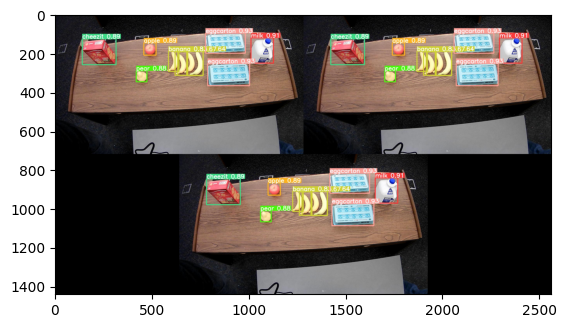

In [33]:
plt.imshow(img123, cmap="gray")

In [34]:
img123 = cv.cvtColor(img123, cv.COLOR_RGB2BGR)

In [35]:
cv.imwrite('./images_OLD/concat.png', img123)

True